# Split data

In [1]:
!ls

README.MD                geometric_library        requirements.txt
__pycache__              install.py               split_process_data.ipynb
create_data.ipynb        install.sh               utils.py
data                     mut_dict


# Omics Data

In [2]:
import os
import csv
from pubchempy import *
import numpy as np
import numbers
import h5py
import math
import pandas as pd
import json,pickle
from collections import OrderedDict
import rdkit
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
import networkx as nx
from utils import *
import random
import pickle
import sys
import matplotlib.pyplot as plt
import argparse
import pickle
from tqdm.notebook import tqdm
import pandas as pd
from ipywidgets import IntProgress
data_split_path = "data/split_data/"
root = "data"

In [3]:
ge = pd.read_csv("data/ge_expression.csv")

In [4]:

def is_not_float(string_list):
    try:
        for string in string_list:
            float(string)
        return False
    except:
        return True

"""
The following 4 function is used to preprocess the drug data. We download the drug list manually, and download the SMILES format using pubchempy. Since this part is time consuming, I write the cids and SMILES into a csv file.
"""
def load_drug_list():
    filename = "data/gdsc/Druglist.csv"
    csvfile = open(filename, "rb")
    reader = csv.reader(csvfile)
    next(reader, None)
    drugs = []
    for line in reader:
        drugs.append(line[0])
    drugs = list(set(drugs))
    return drugs
def atom_features(atom):
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na','Ca', 'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb','Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H','Li', 'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr','Cr', 'Pt', 'Hg', 'Pb', 'Unknown']) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    [atom.GetIsAromatic()])

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

def smile_to_graph(smile):
    mol = Chem.MolFromSmiles(smile)

    c_size = mol.GetNumAtoms()

    features = []
    for atom in mol.GetAtoms():
        feature = atom_features(atom)
        features.append( feature / sum(feature) )

    edges = []
    for bond in mol.GetBonds():
        edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
    g = nx.Graph(edges).to_directed()
    edge_index = []
    for e1, e2 in g.edges:
        edge_index.append([e1, e2])

    return c_size, features, edge_index

def load_drug_smile():
    reader = csv.reader(open("data/smiles.csv"))
    next(reader, None)

    drug_dict = {}
    drug_smile = []

    for item in reader:
        name = item[0]
        smile = item[1]

        if name in drug_dict:
            pos = drug_dict[name]
        else:
            pos = len(drug_dict)
            drug_dict[name] = pos
        drug_smile.append(smile)

    smile_graph = {}
    for smile in drug_smile:
        g = smile_to_graph(smile)
        smile_graph[smile] = g

    return drug_dict, drug_smile, smile_graph
def save_cell_oge_matrix():
    m, n = ge.shape
    feature_names = list(ge.columns[1:])
    cell_dict = {}
    cell_names = []
    for i in tqdm(range(m)):
      cell_name = ge.iloc[i, 0]
      cell_names.append(cell_name)
      cell_feature = np.asarray(ge.iloc[i, 1:], dtype=float)
      cell_dict[cell_name] = cell_feature
    return cell_dict

def save_cell_meth_matrix():
    f = open("data/gdsc/METH_CELLLINES_BEMs_PANCAN.csv")
    reader = csv.reader(f)
    firstRow = next(reader)
    numberCol = len(firstRow) - 1
    features = {}
    cell_dict = {}
    matrix_list = []
    for item in reader:
        cell_id = int(item[0])
        meth = []
        for i in range(1, len(item)):
            meth.append(int(item[i]))
        cell_dict[cell_id] = np.asarray(meth)
    return cell_dict

"""
This part is used to read PANCANCER Gene Expression Cell line features
"""

def save_cell_mut_matrix():
    f = open("data/gdsc/PANCANCER_Genetic_feature.csv")
    reader = csv.reader(f)
    next(reader)
    features = {}
    cell_dict = {}
    mut_dict = {}
    matrix_list = []

    for item in reader:
        cell_id = int(item[1])
        mut = item[5]
        is_mutated = int(item[6])

        if mut in mut_dict:
            col = mut_dict[mut]
        else:
            col = len(mut_dict)
            mut_dict[mut] = col

        if cell_id in cell_dict:
            row = cell_dict[cell_id]
        else:
            row = len(cell_dict)
            cell_dict[cell_id] = row
        if is_mutated == 1:
            matrix_list.append((row, col))

    cell_feature = np.zeros((len(cell_dict), len(mut_dict)))

    for item in matrix_list:
        cell_feature[item[0], item[1]] = 1

    with open('mut_dict', 'wb') as fp:
        pickle.dump(mut_dict, fp)

    return cell_dict, cell_feature

"""
This part is used to read PANCANCER Meth Cell line features
"""


cell_dict_mut, cell_feature_mut = save_cell_mut_matrix()
cell_dict_meth = save_cell_meth_matrix()
cell_dict_ge = save_cell_oge_matrix()
drug_dict, drug_smile, smile_graph = load_drug_smile()

  0%|          | 0/1018 [00:00<?, ?it/s]

In [5]:
cell_gdsc_omics = list(set(cell_dict_ge.keys()).intersection(set(cell_dict_mut.keys())).intersection(set(cell_dict_meth.keys())))

In [6]:
len(cell_gdsc_omics)

765

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm
from collections import defaultdict

In [8]:
cells = pd.read_csv("data/cell_final.csv")
cells

Cell ID Cell line_Oneil
0    906792           A2058
1    906804           A2780
2    906793            A375
3    910851            A427
4    906825          Caov-3
5   1240128             ES2
6    905936          HCT116
7    907067           HT144
8    905939           HT-29
9    907788           LNCAP
10   907790            LOVO
11  1240172        MDAMB436
12   908152            MSTO
13   687800        NCIH1650
14   722046        NCIH2122
15   905942          NCIH23
16   905943        NCI-H460
17   908443         NCIH520
18   909256           OCUBM
19  1240197            OV90
20   905933          OVCAR3
21   909255             PA1
22   909698             RKO
23   910903        RPMI7951
24   909726         SKMEL30
25   909728          SKMES1
26   905959         SK-OV-3
27   905962          SW-620
28   909755           SW837
29   905945           T-47D
30   905976          UACC62
31  1480374         UWB1289
32  1299075            VCAP

In [9]:
ic_50 = pd.read_csv("data/ic_50_datn.csv")

In [10]:
ic_50

Unnamed: 0     Drug name  Drug Id Cell line name  Cosmic sample Id  \
0                0     Erlotinib        1         MC-CAR            683665   
1                1     Erlotinib        1            ES3            684055   
2                2     Erlotinib        1            ES5            684057   
3                3     Erlotinib        1            ES7            684059   
4                4     Erlotinib        1          EW-11            684062   
...            ...           ...      ...            ...               ...   
179645      191822  Pevonedistat     1529       SNU-1040           1659823   
179646      191823  Pevonedistat     1529        SNU-407           1660034   
179647      191824  Pevonedistat     1529         SNU-61           1660035   
179648      191825  Pevonedistat     1529         SNU-81           1660036   
179649      191826  Pevonedistat     1529         SNU-C5           1674021   

       TCGA classification            Tissue                Tissue sub-type  \
0                       MM             blood  haematopoietic_neoplasm_other   
1             UNCLASSIFIED              bone                 ewings_sarcoma   
2             UNCLASSIFIED              bone                 ewings_sarcoma   
3             UNCLASSIFIED              bone                 ewings_sarcoma   
4             UNCLASSIFIED              bone                 ewings_sarcoma   
...                    ...               ...                            ...   
179645              COREAD  digestive_system                large_intestine   
179646              COREAD  digestive_system                large_intestine   
179647              COREAD  digestive_system                large_intestine   
179648              COREAD  digestive_system                large_intestine   
179649              COREAD  digestive_system                large_intestine   

        IC Result ID      IC50       AUC  Max conc      RMSE   Z score  \
0             112389  2.436586  0.982484       2.0  0.021894 -0.013193   
1              46076  3.342826  0.984986       2.0  0.030357  0.777474   
2              46573  3.571787  0.982939       2.0  0.031807  0.977236   
3              47103  3.185231  0.984292       2.0  0.094084  0.639977   
4              49007  2.462555  0.946649       2.0  0.087727  0.009464   
...              ...       ...       ...       ...       ...       ...   
179645        198372  1.379501  0.926174       1.0  0.034162  0.772169   
179646        199227 -0.278601  0.827363       1.0  0.051694 -0.318022   
179647        199956  3.013436  0.976436       1.0  0.040406  1.846470   
179648        200136  0.577129  0.879707       1.0  0.098300  0.244615   
179649        200824 -0.452981  0.817504       1.0  0.038303 -0.432675   

        Dataset version  
0                    17  
1                    17  
2                    17  
3                    17  
4                    17  
...                 ...  
179645               17  
179646               17  
179647               17  
179648               17  
179649               17  

[179650 rows x 15 columns]

In [11]:
loewe = pd.read_csv("data/drug_combination_final.csv")

In [12]:
loewe_cells = list(np.unique(loewe["Cell line"]))

In [13]:
synergy = pd.read_csv("data/labels_deepsynergy.csv").drop(columns=["Unnamed: 0", "fold"])\
                .rename(columns={"drug_a_name":"Drug1", "drug_b_name":"Drug2", "cell_line":"Cell line"})

In [14]:
np.unique(synergy["Cell line"])

array(['A2058', 'A2780', 'A375', 'A427', 'CAOV3', 'COLO320DM', 'DLD1',
       'EFM192B', 'ES2', 'HCT116', 'HT144', 'HT29', 'KPL1', 'LNCAP',
       'LOVO', 'MDAMB436', 'MSTO', 'NCIH1650', 'NCIH2122', 'NCIH23',
       'NCIH460', 'NCIH520', 'OCUBM', 'OV90', 'OVCAR3', 'PA1', 'RKO',
       'RPMI7951', 'SKMEL30', 'SKMES1', 'SKOV3', 'SW620', 'SW837', 'T47D',
       'UACC62', 'UWB1289', 'UWB1289BRCA1', 'VCAP', 'ZR751'], dtype=object)

In [15]:
change_name_cell = {
    "NCIH460":"NCI-H460",
    "SKOV3":"SK-OV-3",
    "SW620":"SW-620",
    "T47D":"T-47D"
}
m, n = synergy.shape
for i in range(m):
    if synergy.loc[i, "Cell line"] in change_name_cell.keys():
        synergy.loc[i, "Cell line"] = change_name_cell[synergy.loc[i, "Cell line"]]

In [16]:
synergy = synergy[synergy["Cell line"].isin(loewe_cells)]
synergy

Drug1      Drug2 Cell line    synergy
0         5-FU    ABT-888     A2058   7.693530
1         5-FU    ABT-888     A2780   7.778053
2         5-FU    ABT-888      A375  -1.198505
3         5-FU    ABT-888      A427   2.595684
8         5-FU    ABT-888       ES2   1.498650
...        ...        ...       ...        ...
23045  ZOLINZA  TOPOTECAN     SW837   3.986551
23046  ZOLINZA  TOPOTECAN     T-47D  18.985100
23047  ZOLINZA  TOPOTECAN    UACC62  10.223066
23049  ZOLINZA  TOPOTECAN   UWB1289  12.190316
23050  ZOLINZA  TOPOTECAN      VCAP  23.438547

[18304 rows x 4 columns]

In [17]:
loewe = synergy.reset_index().drop(columns=["index"])
loewe

Drug1      Drug2 Cell line    synergy
0         5-FU    ABT-888     A2058   7.693530
1         5-FU    ABT-888     A2780   7.778053
2         5-FU    ABT-888      A375  -1.198505
3         5-FU    ABT-888      A427   2.595684
4         5-FU    ABT-888       ES2   1.498650
...        ...        ...       ...        ...
18299  ZOLINZA  TOPOTECAN     SW837   3.986551
18300  ZOLINZA  TOPOTECAN     T-47D  18.985100
18301  ZOLINZA  TOPOTECAN    UACC62  10.223066
18302  ZOLINZA  TOPOTECAN   UWB1289  12.190316
18303  ZOLINZA  TOPOTECAN      VCAP  23.438547

[18304 rows x 4 columns]

In [18]:
loewe.drop_duplicates(keep="first")

Drug1      Drug2 Cell line    synergy
0         5-FU    ABT-888     A2058   7.693530
1         5-FU    ABT-888     A2780   7.778053
2         5-FU    ABT-888      A375  -1.198505
3         5-FU    ABT-888      A427   2.595684
4         5-FU    ABT-888       ES2   1.498650
...        ...        ...       ...        ...
18299  ZOLINZA  TOPOTECAN     SW837   3.986551
18300  ZOLINZA  TOPOTECAN     T-47D  18.985100
18301  ZOLINZA  TOPOTECAN    UACC62  10.223066
18302  ZOLINZA  TOPOTECAN   UWB1289  12.190316
18303  ZOLINZA  TOPOTECAN      VCAP  23.438547

[18304 rows x 4 columns]

In [19]:
len(np.unique(loewe["Cell line"]))

31

In [20]:
drug_pairs = defaultdict(int)
drugs = defaultdict(int)
drug_origin_pairs = defaultdict(int)
m, n = loewe.shape
for i in tqdm(range(m)):
    drug_1 = loewe.loc[i, "Drug1"]
    drug_2 = loewe.loc[i, "Drug2"]
    if drug_1 > drug_2:
        drug_pairs[(drug_1, drug_2)] += 1
    else:
        drug_pairs[(drug_2, drug_1)] += 1
    drugs[drug_1] += 1
    drugs[drug_2] += 1
    drug_origin_pairs[(drug_1, drug_2)] += 1

  0%|          | 0/18304 [00:00<?, ?it/s]

In [21]:
temp = loewe.drop_duplicates(["Drug1", "Drug2"], keep="first").reset_index()
drug_pairs = defaultdict(int)
drugs = defaultdict(int)
drug_origin_pairs = defaultdict(int)
m, n = temp.shape
for i in tqdm(range(m)):
    drug_1 = temp.loc[i, "Drug1"]
    drug_2 = temp.loc[i, "Drug2"]
    if drug_1 > drug_2:
        drug_pairs[(drug_1, drug_2)] += 1
    else:
        drug_pairs[(drug_2, drug_1)] += 1
    drugs[drug_1] += 1
    drugs[drug_2] += 1
    drug_origin_pairs[(drug_1, drug_2)] += 1

  0%|          | 0/583 [00:00<?, ?it/s]

In [22]:
loewe.columns

Index(['Drug1', 'Drug2', 'Cell line', 'synergy'], dtype='object')

In [23]:
def argument_data(df):
    df_argumented = df.rename(columns={"Drug1":"Drug2", "Drug2":"Drug1"})
    df_argumented = df_argumented[['Drug1', 'Drug2', 'Cell line', 'Cosmic sample Id', 'synergy', "Tissue"]]
    df_argumented = df_argumented.append(df).reset_index().drop(columns=["index"])
    return df_argumented

In [24]:
loewe['Cosmic sample Id'] = (pd.Series(loewe["Cell line"].map(dict(zip(cells["Cell line_Oneil"], cells["Cell ID"]))),
                              index=loewe.index)
                      .ffill(downcast='infer'))

In [25]:
loewe = loewe[['Drug1', 'Drug2', 'Cell line', 'Cosmic sample Id', 'synergy']]
loewe

Drug1      Drug2 Cell line  Cosmic sample Id    synergy
0         5-FU    ABT-888     A2058            906792   7.693530
1         5-FU    ABT-888     A2780            906804   7.778053
2         5-FU    ABT-888      A375            906793  -1.198505
3         5-FU    ABT-888      A427            910851   2.595684
4         5-FU    ABT-888       ES2           1240128   1.498650
...        ...        ...       ...               ...        ...
18299  ZOLINZA  TOPOTECAN     SW837            909755   3.986551
18300  ZOLINZA  TOPOTECAN     T-47D            905945  18.985100
18301  ZOLINZA  TOPOTECAN    UACC62            905976  10.223066
18302  ZOLINZA  TOPOTECAN   UWB1289           1480374  12.190316
18303  ZOLINZA  TOPOTECAN      VCAP           1299075  23.438547

[18304 rows x 5 columns]

In [26]:
loewe['Tissue'] = (pd.Series(loewe["Cosmic sample Id"].map(dict(zip(ic_50["Cosmic sample Id"], ic_50["Tissue"]))),
                              index=loewe.index)
                      .ffill(downcast='infer'))

/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/1521842006.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loewe['Tissue'] = (pd.Series(loewe["Cosmic sample Id"].map(dict(zip(ic_50["Cosmic sample Id"], ic_50["Tissue"]))),


In [27]:
loewe = loewe[loewe["Cosmic sample Id"].isin(cell_gdsc_omics)]

In [28]:
loewe = loewe.sample(frac=1)
loewe

Drug1         Drug2 Cell line  Cosmic sample Id    synergy  \
4955      ERLOTINIB    DINACICLIB      A375            906793   9.042391   
980         AZD1775       BEZ-235    UACC62            905976  23.041061   
269            5-FU       L778123  RPMI7951            910903   0.773044   
16995   VINBLASTINE  TEMOZOLOMIDE   SK-OV-3            905959 -52.463226   
6844        L778123     ERLOTINIB   UWB1289           1480374  20.270131   
...             ...           ...       ...               ...        ...   
6248    GEMCITABINE     ERLOTINIB    NCIH23            905942  -7.201436   
7255        L778123     SORAFENIB     SW837            909755  -2.271233   
16854   VINBLASTINE       MK-8776     LNCAP            907788  11.282811   
10296       MK-4541          5-FU     OCUBM            909256   7.744894   
16009  TEMOZOLOMIDE       MK-4827    NCIH23            905942  33.943808   

                  Tissue  
4955                skin  
980                 skin  
269                 skin  
16995  urogenital_system  
6844   urogenital_system  
...                  ...  
6248                lung  
7255    digestive_system  
16854  urogenital_system  
10296             breast  
16009               lung  

[14722 rows x 6 columns]

In [29]:
cells = pd.read_csv("data/cell_final.csv")
cells.head()

Cell ID Cell line_Oneil
0   906792           A2058
1   906804           A2780
2   906793            A375
3   910851            A427
4   906825          Caov-3

In [30]:
# ge_process = pd.read_csv("ge_ex_deepsynergy.csv").rename(columns={"Cosmic sample Id":"GENE_SYMBOLS"})
# ge_process = ge_process.set_index("GENE_SYMBOLS")
# ge_process.head()

In [31]:
ge_process = pd.read_csv("data/ge_expression.csv")
ge_process = ge_process.rename(columns={"Cosmic sample Id":"GENE_SYMBOLS"})
ge_process = ge_process.set_index("GENE_SYMBOLS")

In [32]:
#check distribution
from scipy.stats import ks_2samp

# MIX DATA

## split

In [33]:
train_test_p = 0
train_val_p = 0
while (train_test_p < 0.95) or (train_val_p < 0.95):
    train_dc, test_set = train_test_split(loewe, test_size=0.4)
    val_dc, test_dc = train_test_split(test_set, test_size=0.5)
    train_test_p = ks_2samp(train_dc['synergy'], test_dc['synergy'])[1]
    train_val_p = ks_2samp(train_dc['synergy'], val_dc['synergy'])[1]
#

In [34]:
print(train_dc.shape, val_dc.shape, test_dc.shape)
print(ks_2samp(train_dc['synergy'], test_dc['synergy']))
print(ks_2samp(train_dc['synergy'], val_dc['synergy']))
print(ks_2samp(test_dc['synergy'], val_dc['synergy']))

(8833, 6) (2944, 6) (2945, 6)
KstestResult(statistic=0.009209329807172786, pvalue=0.991002096741879, statistic_location=-2.9319198711, statistic_sign=-1)
KstestResult(statistic=0.010177911758770225, pvalue=0.9738700029883521, statistic_location=-16.5278756461, statistic_sign=1)
KstestResult(statistic=0.014535506016092124, pvalue=0.9073130474052133, statistic_location=-8.8832297519, statistic_sign=1)


## check

KstestResult(statistic=0.009209329807172786, pvalue=0.991002096741879, statistic_location=-2.9319198711, statistic_sign=-1)


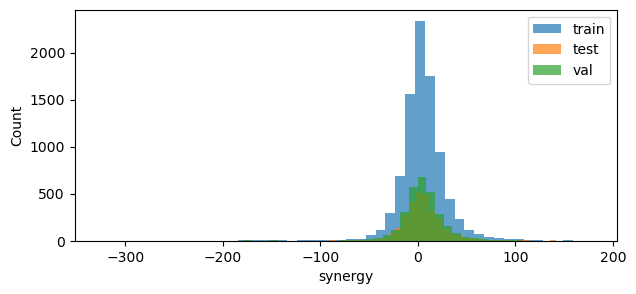

In [35]:
print(ks_2samp(train_dc['synergy'], test_dc['synergy']))
plt.rcParams["figure.figsize"] = (7, 3)
kwargs = dict(histtype='stepfilled', alpha=0.7, bins=50)
plt.hist(train_dc['synergy'], **kwargs)
plt.hist(test_dc['synergy'], **kwargs)
plt.hist(val_dc['synergy'], **kwargs)
plt.legend(["train", "test", "val"])
plt.xlabel("synergy")
plt.ylabel("Count")
plt.show()

In [36]:
# argument
train_dc = argument_data(train_dc)
test_dc = argument_data(test_dc)
val_dc = argument_data(val_dc)

/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/2402413905.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_argumented = df_argumented.append(df).reset_index().drop(columns=["index"])
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/2402413905.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_argumented = df_argumented.append(df).reset_index().drop(columns=["index"])
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/2402413905.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_argumented = df_argumented.append(df).reset_index().drop(columns=["index"])


In [37]:
print(len(np.unique(train_dc["Drug1"])), len(np.unique(test_dc["Drug1"])), len(np.unique(val_dc["Drug1"])))
print(len(np.unique(train_dc["Tissue"])), len(np.unique(test_dc["Tissue"])), len(np.unique(val_dc["Tissue"])))
print(len(np.unique(train_dc["Cosmic sample Id"])), len(np.unique(test_dc["Cosmic sample Id"])), len(np.unique(val_dc["Cosmic sample Id"])))

38 38 38
5 5 5
25 25 25


## nor ge

In [38]:
ge_process_omics = ge_process.copy()

cell_train_idx = pd.Index(set(ge_process.index).intersection(set(np.unique(train_dc["Cosmic sample Id"]))), dtype='int64')
cell_val_idx = pd.Index(set(ge_process.index).intersection(set(np.unique(val_dc["Cosmic sample Id"]))), dtype='int64')
cell_test_idx = pd.Index(set(ge_process.index).intersection(set(np.unique(test_dc["Cosmic sample Id"]))), dtype='int64')

cell_train = ge_process_omics.loc[cell_train_idx, :]
cell_val = ge_process_omics.loc[cell_val_idx, :]
cell_test = ge_process_omics.loc[cell_test_idx, :]

scaler = MinMaxScaler()
scaler.fit(cell_train[list(cell_train.columns)])

ge_process_omics[list(ge_process_omics.columns)] = scaler.transform(ge_process_omics[list(ge_process_omics.columns)])

## save

In [39]:
data_path = "data/split_data/mix_data/"
train_dc.to_csv(data_path + "train_dc.csv", index=False)
test_dc.to_csv(data_path + "test_dc.csv", index=False)
val_dc.to_csv(data_path + "val_dc.csv", index=False)
ge_process_omics.to_csv(data_path + "ge_process_new.csv", index=True, index_label="Cosmic sample Id")

# BLIND CELL

## split

In [40]:
list_drugs = np.unique(list(loewe["Drug1"]) + list(loewe["Drug2"]))
# list_cells = np.unique(loewe["Cell line"])

train_test_p = 0
train_val_p = 0
nt = 0
while (train_test_p < 0.9) or (train_val_p < 0.9):
#     train_cells , test_cells = train_test_split(list_cells, test_size=0.4)
    test_cells = []
    for t in np.unique(loewe["Tissue"]):
        cells = np.unique(loewe[loewe["Tissue"] == t]["Cell line"])
        train_temp, test_cell_temp = train_test_split(cells, test_size=0.2)
        test_cells += list(test_cell_temp)
    train_dc = loewe[loewe["Drug1"].isin(list_drugs)]\
                                        [loewe["Drug2"].isin(list_drugs)]\
                                            [~loewe["Cell line"].isin(test_cells)]

    blind_cell_set = loewe[loewe["Drug1"].isin(list_drugs)]\
                                        [loewe["Drug2"].isin(list_drugs)]\
                                            [loewe["Cell line"].isin(test_cells)]

    val_dc, test_dc = train_test_split(blind_cell_set, test_size=0.5)
    train_test_p = ks_2samp(train_dc['synergy'], test_dc['synergy'])[1]
    train_val_p = ks_2samp(train_dc['synergy'], val_dc['synergy'])[1]
    if (train_test_p> 0.9) or (train_val_p>0.9):
        print(ks_2samp(train_dc['synergy'], test_dc['synergy']))
        print(ks_2samp(train_dc['synergy'], val_dc['synergy']))
        print(ks_2samp(test_dc['synergy'], val_dc['synergy']))
        print("______________________________________________")

print(blind_cell_set.shape)
print(train_dc.shape, val_dc.shape, test_dc.shape)

KstestResult(statistic=0.027810842945548697, pvalue=0.10385279006637216, statistic_location=6.6534475787, statistic_sign=1)
KstestResult(statistic=0.012006387638155536, pvalue=0.9440383059457197, statistic_location=6.3997247103, statistic_sign=1)
KstestResult(statistic=0.021637575888787685, pvalue=0.6297703494311762, statistic_location=12.1835694138, statistic_sign=-1)
______________________________________________
KstestResult(statistic=0.027151943145853806, pvalue=0.11681353537211543, statistic_location=1.7503335885, statistic_sign=-1)
KstestResult(statistic=0.01235069502588789, pvalue=0.9283924441334215, statistic_location=5.3206898969, statistic_sign=-1)
KstestResult(statistic=0.02694171924329751, pvalue=0.34682130903526176, statistic_location=-2.9319198711, statistic_sign=1)
______________________________________________
KstestResult(statistic=0.01086793650010668, pvalue=0.975168950338038, statistic_location=-24.8881583464, statistic_sign=-1)
KstestResult(statistic=0.0226786781267

In [41]:
print(train_dc.shape, val_dc.shape, test_dc.shape)
print(ks_2samp(train_dc['synergy'], test_dc['synergy']))
print(ks_2samp(train_dc['synergy'], val_dc['synergy']))
print(ks_2samp(test_dc['synergy'], val_dc['synergy']))

(10016, 6) (2353, 6) (2353, 6)
KstestResult(statistic=0.010786566398140351, pvalue=0.9779446803018105, statistic_location=-4.8381543922, statistic_sign=-1)
KstestResult(statistic=0.012320788226300783, pvalue=0.9310840701871328, statistic_location=20.5148439326, statistic_sign=1)
KstestResult(statistic=0.014024649383765405, pvalue=0.9748410584828118, statistic_location=-4.7173256594, statistic_sign=1)


## check

In [42]:
print(len(np.unique(train_dc["Drug1"])), len(np.unique(test_dc["Drug1"])), len(np.unique(val_dc["Drug1"])))
print(len(np.unique(train_dc["Tissue"])), len(np.unique(test_dc["Tissue"])), len(np.unique(val_dc["Tissue"])))
print(len(np.unique(train_dc["Cosmic sample Id"])), len(np.unique(test_dc["Cosmic sample Id"])), len(np.unique(val_dc["Cosmic sample Id"])))

37 37 37
5 5 5
17 8 8


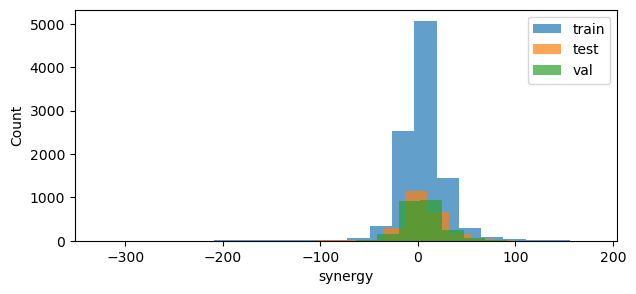

In [43]:
plt.rcParams["figure.figsize"] = (7, 3)
kwargs = dict(histtype='stepfilled', alpha=0.7, bins=20)
plt.hist(train_dc['synergy'], **kwargs)
plt.hist(test_dc['synergy'], **kwargs)
plt.hist(val_dc['synergy'], **kwargs)
plt.legend(["train", "test", "val"])
plt.xlabel("synergy")
plt.ylabel("Count")
plt.show()

## nor ge

In [44]:
ge_process_omics = ge_process.copy()

cell_train_idx = pd.Index(set(ge_process.index).intersection(set(np.unique(train_dc["Cosmic sample Id"]))), dtype='int64')
cell_val_idx = pd.Index(set(ge_process.index).intersection(set(np.unique(val_dc["Cosmic sample Id"]))), dtype='int64')
cell_test_idx = pd.Index(set(ge_process.index).intersection(set(np.unique(test_dc["Cosmic sample Id"]))), dtype='int64')

cell_train = ge_process_omics.loc[cell_train_idx, :]
cell_val = ge_process_omics.loc[cell_val_idx, :]
cell_test = ge_process_omics.loc[cell_test_idx, :]

scaler = MinMaxScaler()
scaler.fit(cell_train[list(cell_train.columns)])

ge_process_omics[list(ge_process_omics.columns)] = scaler.transform(ge_process_omics[list(ge_process_omics.columns)])

In [45]:
# argument
train_dc = argument_data(train_dc)
test_dc = argument_data(test_dc)
val_dc = argument_data(val_dc)

/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/2402413905.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_argumented = df_argumented.append(df).reset_index().drop(columns=["index"])
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/2402413905.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_argumented = df_argumented.append(df).reset_index().drop(columns=["index"])
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/2402413905.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_argumented = df_argumented.append(df).reset_index().drop(columns=["index"])


In [46]:
test_dc.shape

(4706, 6)

## save

In [47]:
data_path = "data/split_data/blind_cell/"
train_dc.to_csv(data_path + "train_dc.csv", index=False)
test_dc.to_csv(data_path + "test_dc.csv", index=False)
val_dc.to_csv(data_path + "val_dc.csv", index=False)
ge_process_omics.to_csv(data_path + "ge_process.csv", index=True, index_label="Cosmic sample Id")

# Blind drug

## split

In [48]:
list_drugs = np.unique(list(loewe["Drug1"]) + list(loewe["Drug2"]))
list_cells = np.unique(loewe["Cell line"])
train_test_p = 0
train_val_p = 0
while (train_test_p < 0.85) or (train_val_p < 0.85):
    train_drugs, test_drugs = train_test_split(list_drugs, test_size=0.2)
    train_dc = loewe[loewe["Drug1"].isin(train_drugs)]\
                                        [loewe["Drug2"].isin(train_drugs)]\
                                            [loewe["Cell line"].isin(list_cells)]

    #blind 1 drug
    blind_1_drug_set = loewe[loewe["Drug1"].isin(train_drugs)]\
                                        [~loewe["Drug2"].isin(train_drugs)]\
                                            [loewe["Cell line"].isin(list_cells)].append(
                            loewe[~loewe["Drug1"].isin(train_drugs)]\
                                                            [loewe["Drug2"].isin(train_drugs)]\
                                                                [loewe["Cell line"].isin(list_cells)]
    ).reset_index().drop(columns=["index"])
    #blind 2 drug
    blind_2_drug_set = loewe[loewe["Drug1"].isin(test_drugs)]\
                                        [loewe["Drug2"].isin(test_drugs)]\
                                            [loewe["Cell line"].isin(list_cells)]

    blind_drug_set = blind_1_drug_set.append(blind_2_drug_set)

    val_dc, test_dc = train_test_split(blind_drug_set, test_size=0.5)
    train_test_p = ks_2samp(train_dc['synergy'], test_dc['synergy'])[1]
    train_val_p = ks_2samp(train_dc['synergy'], val_dc['synergy'])[1]
    if (train_test_p > 0.85) or (train_val_p > 0.85):
        print(ks_2samp(train_dc['synergy'], test_dc['synergy']))
        print(ks_2samp(train_dc['synergy'], val_dc['synergy']))
        print(ks_2samp(test_dc['synergy'], val_dc['synergy']))
        print("______________________________________________")


print(train_dc.shape, val_dc.shape, test_dc.shape)

/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_dc = loewe[loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  blind_1_drug_set = loewe[loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  loewe[~loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  [loewe["Cell line"].isin(list_cells)].append(
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:20: UserWarning: Boolean S

KstestResult(statistic=0.019578710558492828, pvalue=0.37044805795637326, statistic_location=2.7564081683, statistic_sign=1)
KstestResult(statistic=0.012369512291751794, pvalue=0.88894748033253, statistic_location=-2.9127082867, statistic_sign=1)
KstestResult(statistic=0.02027972027972028, pvalue=0.5989167170999454, statistic_location=9.6074866741, statistic_sign=-1)
______________________________________________
KstestResult(statistic=0.018111798806041236, pvalue=0.4701507704980475, statistic_location=12.4876528654, statistic_sign=1)
KstestResult(statistic=0.011225017879808773, pvalue=0.9444774987946908, statistic_location=-32.1082134831, statistic_sign=-1)
KstestResult(statistic=0.020379479971890373, pvalue=0.595769354634008, statistic_location=-5.4789686334, statistic_sign=-1)
______________________________________________


/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_dc = loewe[loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  blind_1_drug_set = loewe[loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  loewe[~loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  [loewe["Cell line"].isin(list_cells)].append(
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:20: UserWarning: Boolean S

KstestResult(statistic=0.019972793511470445, pvalue=0.34687936732409447, statistic_location=11.1138503239, statistic_sign=1)
KstestResult(statistic=0.01290457908104967, pvalue=0.8573284426748801, statistic_location=-24.7753783885, statistic_sign=-1)
KstestResult(statistic=0.02259561507487139, pvalue=0.4492443171986869, statistic_location=5.8090332677, statistic_sign=-1)
______________________________________________


/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_dc = loewe[loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  blind_1_drug_set = loewe[loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  loewe[~loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  [loewe["Cell line"].isin(list_cells)].append(
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:20: UserWarning: Boolean S

KstestResult(statistic=0.012068888441681113, pvalue=0.8949871779706119, statistic_location=-9.1328075497, statistic_sign=1)
KstestResult(statistic=0.019545603165213893, pvalue=0.35346049550746805, statistic_location=29.6750915059, statistic_sign=1)
KstestResult(statistic=0.017224246439218285, pvalue=0.7617911624140838, statistic_location=7.3589501129, statistic_sign=-1)
______________________________________________


/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_dc = loewe[loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  blind_1_drug_set = loewe[loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  loewe[~loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  [loewe["Cell line"].isin(list_cells)].append(
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:20: UserWarning: Boolean S

KstestResult(statistic=0.012344733608359424, pvalue=0.8913660746629588, statistic_location=7.650514826, statistic_sign=1)
KstestResult(statistic=0.01992553905969716, pvalue=0.3511084651356115, statistic_location=8.8828429883, statistic_sign=1)
KstestResult(statistic=0.014406184118060435, pvalue=0.9293213608076769, statistic_location=8.5049595847, statistic_sign=1)
______________________________________________


/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_dc = loewe[loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  blind_1_drug_set = loewe[loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  loewe[~loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  [loewe["Cell line"].isin(list_cells)].append(
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:20: UserWarning: Boolean S

KstestResult(statistic=0.015340053048004836, pvalue=0.6427329541543623, statistic_location=27.9568856891, statistic_sign=-1)
KstestResult(statistic=0.009635795188870859, pvalue=0.9813357569479582, statistic_location=-3.4775773022, statistic_sign=-1)
KstestResult(statistic=0.01648084910888088, pvalue=0.7706538011228253, statistic_location=2.9441074197, statistic_sign=-1)
______________________________________________


/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_dc = loewe[loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  blind_1_drug_set = loewe[loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  loewe[~loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  [loewe["Cell line"].isin(list_cells)].append(
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:20: UserWarning: Boolean S

KstestResult(statistic=0.010374263569586963, pvalue=0.9758276049120762, statistic_location=7.320155847, statistic_sign=1)
KstestResult(statistic=0.0243711177029467, pvalue=0.16314430823598075, statistic_location=8.3085613324, statistic_sign=-1)
KstestResult(statistic=0.03208883948787617, pvalue=0.11941679994285836, statistic_location=8.6994026516, statistic_sign=-1)
______________________________________________


/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_dc = loewe[loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  blind_1_drug_set = loewe[loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  loewe[~loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  [loewe["Cell line"].isin(list_cells)].append(
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:20: UserWarning: Boolean S

KstestResult(statistic=0.016370876933786662, pvalue=0.5607911415882, statistic_location=15.8823326119, statistic_sign=1)
KstestResult(statistic=0.010472971651106564, pvalue=0.9594853134724757, statistic_location=33.345947714, statistic_sign=-1)
KstestResult(statistic=0.019755401107931773, pvalue=0.5531176816586523, statistic_location=15.7824089295, statistic_sign=-1)
______________________________________________


/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_dc = loewe[loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  blind_1_drug_set = loewe[loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  loewe[~loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  [loewe["Cell line"].isin(list_cells)].append(
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:20: UserWarning: Boolean S

KstestResult(statistic=0.009207211927945458, pvalue=0.9903364736805209, statistic_location=0.5820527198, statistic_sign=-1)
KstestResult(statistic=0.03525439897495936, pvalue=0.007465282687040407, statistic_location=-1.8241671119, statistic_sign=-1)
KstestResult(statistic=0.03419654714475431, pvalue=0.059058633247205485, statistic_location=-1.618527955, statistic_sign=-1)
______________________________________________


/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_dc = loewe[loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  blind_1_drug_set = loewe[loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  loewe[~loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  [loewe["Cell line"].isin(list_cells)].append(
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:20: UserWarning: Boolean S

KstestResult(statistic=0.012434222076523787, pvalue=0.8852667036419006, statistic_location=39.0531664387, statistic_sign=-1)
KstestResult(statistic=0.018970298752569358, pvalue=0.40938917064506813, statistic_location=4.4787374533, statistic_sign=1)
KstestResult(statistic=0.015734265734265736, pvalue=0.870923420651597, statistic_location=-5.8963232641, statistic_sign=-1)
______________________________________________


/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_dc = loewe[loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  blind_1_drug_set = loewe[loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  loewe[~loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  [loewe["Cell line"].isin(list_cells)].append(
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:20: UserWarning: Boolean S

KstestResult(statistic=0.013362115751068864, pvalue=0.8276189542299324, statistic_location=9.5804858589, statistic_sign=1)
KstestResult(statistic=0.012910451521165317, pvalue=0.8571838324523825, statistic_location=-19.2090135213, statistic_sign=1)
KstestResult(statistic=0.012618296529968454, pvalue=0.9770246551859322, statistic_location=8.1747004087, statistic_sign=-1)
______________________________________________


/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_dc = loewe[loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  blind_1_drug_set = loewe[loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  loewe[~loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  [loewe["Cell line"].isin(list_cells)].append(
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:20: UserWarning: Boolean S

KstestResult(statistic=0.012520194129685388, pvalue=0.9138240942220353, statistic_location=-6.3480466167, statistic_sign=-1)
KstestResult(statistic=0.013356901947625262, pvalue=0.8700062935821564, statistic_location=-9.9393586243, statistic_sign=1)
KstestResult(statistic=0.021101101522205394, pvalue=0.634305518525693, statistic_location=-1.4602356783, statistic_sign=1)
______________________________________________
(9827, 6) (2447, 6) (2448, 6)


/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/248842358.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  blind_drug_set = blind_1_drug_set.append(blind_2_drug_set)


In [49]:
print(train_dc.shape, val_dc.shape, test_dc.shape)

(9827, 6) (2447, 6) (2448, 6)


In [50]:
print(train_dc.shape, val_dc.shape, test_dc.shape)
print(ks_2samp(train_dc['synergy'], test_dc['synergy']))
print(ks_2samp(train_dc['synergy'], val_dc['synergy']))
print(ks_2samp(test_dc['synergy'], val_dc['synergy']))

(9827, 6) (2447, 6) (2448, 6)
KstestResult(statistic=0.012520194129685388, pvalue=0.9138240942220353, statistic_location=-6.3480466167, statistic_sign=-1)
KstestResult(statistic=0.013356901947625262, pvalue=0.8700062935821564, statistic_location=-9.9393586243, statistic_sign=1)
KstestResult(statistic=0.021101101522205394, pvalue=0.634305518525693, statistic_location=-1.4602356783, statistic_sign=1)


## check

In [51]:
print(len(np.unique(train_dc["Drug1"])), len(np.unique(test_dc["Drug1"])), len(np.unique(val_dc["Drug1"])))
print(len(np.unique(train_dc["Tissue"])), len(np.unique(test_dc["Tissue"])), len(np.unique(val_dc["Tissue"])))
print(len(np.unique(train_dc["Cosmic sample Id"])), len(np.unique(test_dc["Cosmic sample Id"])), len(np.unique(val_dc["Cosmic sample Id"])))

29 37 37
5 5 5
25 25 25


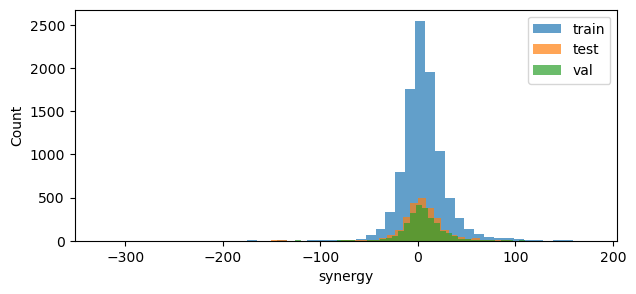

In [52]:
plt.rcParams["figure.figsize"] = (7, 3)
kwargs = dict(histtype='stepfilled', alpha=0.7, bins=50)
plt.hist(train_dc['synergy'], **kwargs)
plt.hist(test_dc['synergy'], **kwargs)
plt.hist(val_dc['synergy'], **kwargs)
plt.legend(["train", "test", "val"])
plt.xlabel("synergy")
plt.ylabel("Count")
plt.show()

## nor ge

In [53]:
len(np.unique(test_dc["Drug1"]))

37

In [54]:
ge_process_omics = ge_process.copy()
cell_train_idx = pd.Index(set(ge_process.index).intersection(set(np.unique(train_dc["Cosmic sample Id"]))), dtype='int64')
cell_val_idx = pd.Index(set(ge_process.index).intersection(set(np.unique(val_dc["Cosmic sample Id"]))), dtype='int64')
cell_test_idx = pd.Index(set(ge_process.index).intersection(set(np.unique(test_dc["Cosmic sample Id"]))), dtype='int64')

cell_train = ge_process_omics.loc[cell_train_idx, :]
cell_val = ge_process_omics.loc[cell_val_idx, :]
cell_test = ge_process_omics.loc[cell_test_idx, :]

scaler = MinMaxScaler()
scaler.fit(cell_train[list(cell_train.columns)])

ge_process_omics[list(ge_process_omics.columns)] = scaler.transform(ge_process_omics[list(ge_process_omics.columns)])

In [55]:
# argument
train_dc = argument_data(train_dc)
test_dc = argument_data(test_dc)
val_dc = argument_data(val_dc)

/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/2402413905.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_argumented = df_argumented.append(df).reset_index().drop(columns=["index"])
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/2402413905.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_argumented = df_argumented.append(df).reset_index().drop(columns=["index"])
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/2402413905.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_argumented = df_argumented.append(df).reset_index().drop(columns=["index"])


## save

In [56]:
data_path = "data/split_data/blind_drug/"
train_dc.to_csv(data_path + "train_dc.csv", index=False)
test_dc.to_csv(data_path + "test_dc.csv", index=False)
val_dc.to_csv(data_path + "val_dc.csv", index=False)
ge_process_omics.to_csv(data_path + "ge_process_new.csv", index=True, index_label="Cosmic sample Id")

# ALL TEST

In [57]:
import pandas as pd
import numpy as np

test_drugs = list(set(np.unique(pd.read_csv("data/split_data/blind_drug/test_dc.csv")["Drug1"])) - set(np.unique(pd.read_csv("data/split_data/blind_drug/train_dc.csv")["Drug1"])))
train_drugs = np.unique(pd.read_csv("data/split_data/blind_drug/train_dc.csv")["Drug1"])

test_cells = np.unique(pd.read_csv("data/split_data/blind_cell/test_dc.csv")["Cell line"])
train_cells = np.unique(pd.read_csv("data/split_data/blind_cell/train_dc.csv")["Cell line"])
print(len(test_cells), len(train_cells))
print(len(test_drugs), len(train_drugs))

8 17
8 30


In [58]:
# train_drugs, test_drugs = train_test_split(list_drugs, test_size=0.15)
# train_cells , test_cells = train_test_split(list_cells, test_size=0.15)

In [59]:
loewe[loewe["Cell line"].isin(test_cells)].drop_duplicates(["Cell line"])

Drug1        Drug2 Cell line  Cosmic sample Id    synergy  \
16405    TOPOTECAN    SORAFENIB    SKMES1            909728   9.200604   
10323      MK-4541      ABT-888  NCIH2122            722046  -5.243411   
10953      MK-4541      MK-4827   SKMEL30            909726   5.095555   
14179   PACLITAXEL    LAPATINIB     A2058            906792  -5.178458   
13885  OXALIPLATIN    SORAFENIB     OCUBM            909256  -3.273753   
1363       AZD1775  OXALIPLATIN      OV90           1240197 -21.616711   
18144      ZOLINZA     PD325901     SW837            909755   0.031109   
4971     ERLOTINIB   DINACICLIB    OVCAR3            905933  14.143114   

                  Tissue  
16405               lung  
10323               lung  
10953               skin  
14179               skin  
13885             breast  
1363   urogenital_system  
18144   digestive_system  
4971   urogenital_system

In [60]:
test_cells

array(['A2058', 'NCIH2122', 'OCUBM', 'OV90', 'OVCAR3', 'SKMEL30',
       'SKMES1', 'SW837'], dtype=object)

In [61]:
#train set
train_set = loewe[loewe["Drug1"].isin(train_drugs)]\
                                    [loewe["Drug2"].isin(train_drugs)]\
                                        [loewe["Cell line"].isin(train_cells)]

/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/3560956105.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_set = loewe[loewe["Drug1"].isin(train_drugs)]\


In [62]:
#blind cell
blind_cell_set = loewe[loewe["Drug1"].isin(train_drugs)]\
                                    [loewe["Drug2"].isin(train_drugs)]\
                                        [loewe["Cell line"].isin(test_cells)]
print(blind_cell_set.shape)

(3142, 6)


/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/3684265424.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  blind_cell_set = loewe[loewe["Drug1"].isin(train_drugs)]\


In [63]:
#blind 1 drug
blind_1_drug_set = loewe[loewe["Drug1"].isin(train_drugs)]\
                                    [~loewe["Drug2"].isin(train_drugs)]\
                                        [loewe["Cell line"].isin(train_cells)].append(
                        loewe[~loewe["Drug1"].isin(train_drugs)]\
                                                        [loewe["Drug2"].isin(train_drugs)]\
                                                            [loewe["Cell line"].isin(train_cells)]
).reset_index().drop(columns=["index"])
print(blind_1_drug_set.shape)

(3090, 6)


/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/1226268009.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  blind_1_drug_set = loewe[loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/1226268009.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  loewe[~loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/1226268009.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  [loewe["Cell line"].isin(train_cells)].append(


In [64]:
#blind 1 drug and cell
blind_1_drug_cell_set = loewe[loewe["Drug1"].isin(train_drugs)]\
                                    [~loewe["Drug2"].isin(train_drugs)]\
                                        [loewe["Cell line"].isin(test_cells)].append(
                        loewe[~loewe["Drug1"].isin(train_drugs)]\
                                                        [loewe["Drug2"].isin(train_drugs)]\
                                                            [loewe["Cell line"].isin(test_cells)]
).reset_index().drop(columns=["index"])
print(blind_1_drug_cell_set.shape)

(1452, 6)


/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/326835439.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  blind_1_drug_cell_set = loewe[loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/326835439.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  loewe[~loewe["Drug1"].isin(train_drugs)]\
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/326835439.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  [loewe["Cell line"].isin(test_cells)].append(


In [65]:
#blind 2 drug
blind_2_drug_set = loewe[loewe["Drug1"].isin(test_drugs)]\
                                    [loewe["Drug2"].isin(test_drugs)]\
                                        [loewe["Cell line"].isin(train_cells)]
print(blind_2_drug_set.shape)

(241, 6)


/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/2983045700.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  blind_2_drug_set = loewe[loewe["Drug1"].isin(test_drugs)]\


In [66]:
#blind all
blind_all_set = loewe[loewe["Drug1"].isin(test_drugs)]\
                                    [loewe["Drug2"].isin(test_drugs)]\
                                        [loewe["Cell line"].isin(test_cells)]
print(blind_all_set.shape)

(112, 6)


/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/1564163953.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  blind_all_set = loewe[loewe["Drug1"].isin(test_drugs)]\


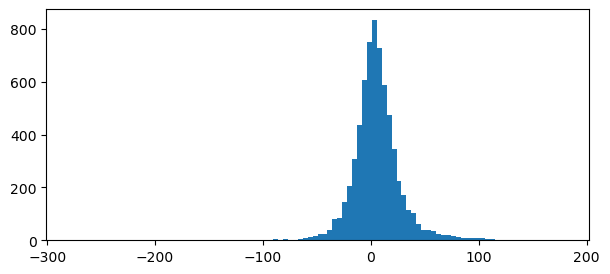

In [67]:
plt.hist(train_set["synergy"], bins=100)
plt.show()

In [68]:
train_dc, mix_set = train_test_split(train_set, test_size=0.2)

In [69]:
mix_val, mix_test = train_test_split(mix_set, test_size=0.5)
blind_cell_val, blind_cell_test = train_test_split(blind_cell_set, test_size=0.5)
blind_1_drug_val, blind_1_drug_test = train_test_split(blind_1_drug_set, test_size=0.5)
blind_1_drug_cell_val, blind_1_drug_cell_test = train_test_split(blind_1_drug_cell_set, test_size=0.5)
blind_2_drug_val, blind_2_drug_test = train_test_split(blind_2_drug_set, test_size=0.5)
blind_all_val, blind_all_test = train_test_split(blind_all_set, test_size=0.5)

In [70]:
print(len(np.unique(mix_val["Drug1"])), len(np.unique(mix_val["Drug2"])), len(np.unique(mix_val["Cell line"])))
print(len(np.unique(mix_set["Drug1"])), len(np.unique(mix_set["Drug2"])), len(np.unique(mix_set["Cell line"])))

29 29 17
29 29 17


In [71]:
print(len(np.unique(train_dc["Drug1"])), len(np.unique(train_dc["Drug2"])), len(np.unique(train_dc["Cell line"])))

29 29 17


In [72]:
print(set(np.unique(blind_cell_val["Drug1"]))-set(train_drugs))
print(set(np.unique(blind_cell_val["Drug2"]))-set(train_drugs))
print(set(np.unique(blind_cell_val["Cell line"])).intersection(set(train_cells)))
print("___")
print(set(np.unique(blind_cell_test["Drug1"]))-set(train_drugs))
print(set(np.unique(blind_cell_test["Drug2"]))-set(train_drugs))
print(set(np.unique(blind_cell_test["Cell line"])).intersection(set(train_cells)))

set()
set()
set()
___
set()
set()
set()


In [73]:
train_dc = train_dc
val_dc = pd.concat([mix_val, blind_cell_val, blind_1_drug_val, blind_1_drug_cell_val, blind_2_drug_val, blind_all_val])
test_dc = pd.concat([mix_test, blind_cell_test, blind_1_drug_test, blind_1_drug_cell_test, blind_2_drug_test, blind_all_test])

In [74]:
train_dc = argument_data(train_dc)
test_dc = argument_data(test_dc)
val_dc = argument_data(val_dc)

mix_val = argument_data(mix_val)
mix_test = argument_data(mix_test)

blind_cell_val = argument_data(blind_cell_val)
blind_cell_test = argument_data(blind_cell_test)

blind_1_drug_val = argument_data(blind_1_drug_val)
blind_1_drug_test = argument_data(blind_1_drug_test)

blind_1_drug_cell_val = argument_data(blind_1_drug_cell_val)
blind_1_drug_cell_test = argument_data(blind_1_drug_cell_test)

blind_2_drug_val = argument_data(blind_2_drug_val)
blind_2_drug_test = argument_data(blind_2_drug_test)

blind_all_val = argument_data(blind_all_val)
blind_all_test = argument_data(blind_all_test)

/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/2402413905.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_argumented = df_argumented.append(df).reset_index().drop(columns=["index"])
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/2402413905.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_argumented = df_argumented.append(df).reset_index().drop(columns=["index"])
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/2402413905.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_argumented = df_argumented.append(df).reset_index().drop(columns=["index"])
/var/folders/t8/pj7tbdcs7cl0l98rx9460zb992t4z9/T/ipykernel_17189/2402413905.py:4: FutureWarning: The frame.appen

In [75]:
print(train_dc.shape[0] + test_dc.shape[0] + val_dc.shape[0])

29444


In [76]:
print(len(np.unique(test_dc["Cell line"])), len(np.unique(val_dc["Cell line"])), len(np.unique(train_dc["Cell line"])))

25 25 17


In [1]:
cells = pd.read_csv("data/cell_final.csv")
cells.head()
ge_process = pd.read_csv("data/gdsc/ge_expression.csv")
ge_process = ge_process.rename(columns={"Unnamed: 0":"GENE_SYMBOLS"})
ge_process = ge_process.set_index("GENE_SYMBOLS")

NameError: name 'pd' is not defined

# GE

In [ ]:
ge_process

TSPAN6      TNMD       DPM1     SCYL3  C1orf112       FGR  \
GENE_SYMBOLS                                                                
906826        7.632023  2.964585  10.379553  3.614794  3.380681  3.324692   
687983        7.548671  2.777716  11.807341  4.066887  3.732485  3.152404   
910927        8.712338  2.643508   9.880733  3.956230  3.236620  3.241246   
1240138       7.797142  2.817923   9.883471  4.063701  3.558414  3.101247   
1240139       7.729268  2.957739  10.418840  4.341500  3.840373  3.001802   
...                ...       ...        ...       ...       ...       ...   
1298157       8.441628  2.639276  11.463742  4.425849  4.384732  3.229511   
1480372       8.422922  2.879890  10.557777  3.550390  4.247189  3.176336   
1298533       8.089255  2.521169  10.792750  4.443337  3.071359  3.238305   
930299        3.112333  2.870468   9.873902  4.266828  3.230197  3.027742   
905954        7.153127  2.834285  10.788218  4.100493  3.435795  3.330279   

                   CFH     FUCA2      GCLC      NFYA  ...  LINC00526  \
GENE_SYMBOLS                                          ...              
906826        3.566350  8.204530  5.235118  5.369039  ...   6.786925   
687983        7.827172  6.616972  5.809264  7.209653  ...   5.317911   
910927        2.931034  8.191246  5.426841  5.120747  ...   3.143006   
1240138       7.211707  8.630643  5.617714  4.996434  ...   3.153896   
1240139       3.375422  8.296950  5.669418  4.180205  ...   3.652660   
...                ...       ...       ...       ...  ...        ...   
1298157       3.571204  8.193000  5.671600  4.943996  ...   5.097882   
1480372       3.321811  8.901706  4.684851  4.215908  ...   4.243448   
1298533       5.209472  8.073389  5.643811  5.040952  ...   5.084844   
930299        3.407148  5.760610  5.834256  5.550722  ...   4.986124   
905954        3.063284  8.191465  5.329834  5.877487  ...   4.362137   

                  PPY2  Unnamed: 17730  Unnamed: 17731  KRT18P55  \
GENE_SYMBOLS                                                       
906826        2.997054        3.109774        7.882377  3.331134   
687983        3.263745        3.059424        8.681302  2.992611   
910927        3.112145        2.930254        8.707886  2.886574   
1240138       3.151576        2.850726        7.872535  3.812119   
1240139       2.918475        2.849537        8.945953  3.412586   
...                ...             ...             ...       ...   
1298157       3.102979        3.243552        8.110421  3.343723   
1480372       3.034131        3.031143        9.161868  3.412558   
1298533       2.981869        3.703721        8.473612  3.640390   
930299        2.992148        3.111383        8.468564  3.142641   
905954        2.964605        3.300715        8.386096  2.927523   

              Unnamed: 17733  POLRMTP1     UBL5P2  TBC1D3P5  Unnamed: 17737  
GENE_SYMBOLS                                                                 
906826              2.852537  3.130696   9.986616  3.073724        7.284733  
687983              2.776771  3.260982   9.002814  3.000182        8.504804  
910927              2.685307  3.176239   9.113243  2.916274        7.059092  
1240138             3.436412  3.074432   9.958284  3.256500        7.318125  
1240139             2.951270  3.213545   9.938978  3.396126        7.726867  
...                      ...       ...        ...       ...             ...  
1298157             2.959009  3.007502   9.332193  3.435411       10.392042  
1480372             2.974475  3.088841  10.742651  3.317945        6.203929  
1298533             2.903894  2.847505   8.544696  3.174515        7.119213  
930299              2.857956  2.832840   9.900550  3.243563        7.622261  
905954              3.033662  2.817057   9.071943  3.324517        7.290293  

[1018 rows x 17737 columns]

In [ ]:
train_dc['IC50'] = train_dc['IC50'].apply(lambda x: 1/(1 + np.exp((-0.1)*x)))

In [ ]:
test_dc['IC50'] = test_dc['IC50'].apply(lambda x: 1/(1 + np.exp((-0.1)*x)))
val_dc['IC50'] = val_dc['IC50'].apply(lambda x: 1/(1 + np.exp((-0.1)*x)))

In [ ]:
print(np.unique(blind_cell_set["Cell line"]))
print(np.unique(blind_cell_set["Tissue"]))
print(np.unique(train_dc["Tissue"], return_counts=True))

['LNCAP' 'MDAMB436' 'NCIH1650' 'OVCAR3' 'RKO' 'RPMI7951' 'SKMEL30'
 'SKMES1']
['breast' 'digestive_system' 'lung' 'skin' 'urogenital_system']
(array(['breast', 'digestive_system', 'lung', 'skin', 'urogenital_system'],
      dtype=object), array([1324, 2032, 2722, 2752, 2682]))


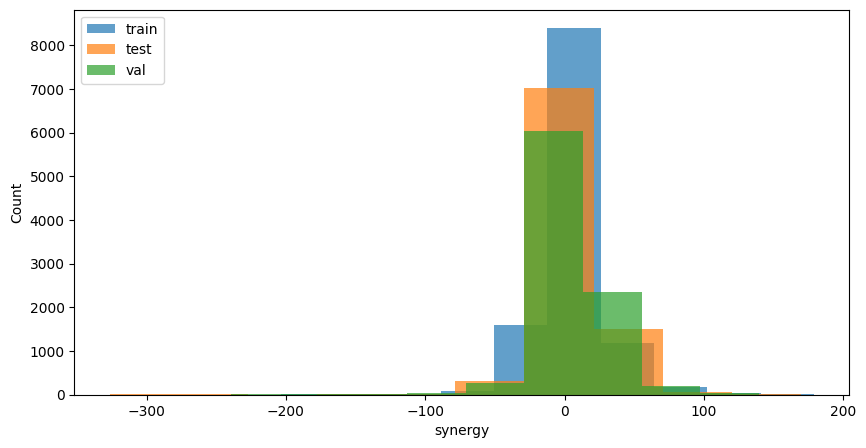

In [ ]:
plt.rcParams["figure.figsize"] = (10, 5)
kwargs = dict(histtype='stepfilled', alpha=0.7, bins=10)
plt.hist(train_dc['synergy'], **kwargs)
plt.hist(test_dc['synergy'], **kwargs)
plt.hist(val_dc['synergy'], **kwargs)
plt.legend(["train", "test", "val"])
plt.xlabel("synergy")
plt.ylabel("Count")
plt.show()

In [ ]:
print(train_dc.shape, val_dc.shape, test_dc.shape)

(11512, 6) (8964, 6) (8968, 6)


In [ ]:
print(len(np.unique(train_dc["Cosmic sample Id"])), len(np.unique(val_dc["Cosmic sample Id"])), len(np.unique(test_dc["Cosmic sample Id"])))

17 25 25


In [ ]:
# set(ge_process.index).intersection(set(np.unique(train_dc["Cosmic sample Id"])))

In [ ]:
cell_train_idx = pd.Index(set(ge_process.index).intersection(set(np.unique(train_dc["Cosmic sample Id"]))), dtype='int64')
cell_val_idx = pd.Index(set(ge_process.index).intersection(set(np.unique(val_dc["Cosmic sample Id"]))), dtype='int64')
cell_test_idx = pd.Index(set(ge_process.index).intersection(set(np.unique(test_dc["Cosmic sample Id"]))), dtype='int64')

cell_train = ge_process.loc[cell_train_idx, :]
cell_val = ge_process.loc[cell_val_idx, :]
cell_test = ge_process.loc[cell_test_idx, :]

scaler = MinMaxScaler()
scaler.fit(cell_train[list(cell_train.columns)])

ge_process[list(ge_process.columns)] = scaler.transform(ge_process[list(ge_process.columns)])

In [ ]:
ge_process.head()

TSPAN6      TNMD      DPM1     SCYL3  C1orf112       FGR  \
GENE_SYMBOLS                                                               
906826        0.765591  0.590642  0.721936  0.026371  0.289824  0.666291   
687983        0.737651  0.186554  1.469616  0.258142  0.568452  0.298153   
910927        1.127709 -0.103660  0.460723  0.201412  0.175727  0.487987   
1240138       0.820938  0.273498  0.462157  0.256509  0.430588  0.188840   
1240139       0.798187  0.575838  0.742510  0.398925  0.653900 -0.023650   

                   CFH     FUCA2      GCLC      NFYA  ...  LINC00526  \
GENE_SYMBOLS                                          ...              
906826        0.166175  0.731297  0.067800  0.665695  ...   1.402451   
687983        1.330556  0.376535  0.264517  1.844070  ...   0.895185   
910927       -0.007442  0.728329  0.133489  0.506736  ...   0.144168   
1240138       1.162364  0.826518  0.198887  0.427150  ...   0.147929   
1240139       0.113998  0.751950  0.216602 -0.095406  ...   0.320157   

                  PPY2  Unnamed: 17730  Unnamed: 17731  KRT18P55  \
GENE_SYMBOLS                                                       
906826        0.010251        0.066878       -0.050665  0.492750   
687983        0.570096        0.044123        0.330840 -0.010447   
910927        0.251853       -0.014251        0.343535 -0.168067   
1240138       0.334628       -0.050192       -0.055365  1.207710   
1240139      -0.154705       -0.050729        0.457218  0.613824   

              Unnamed: 17733  POLRMTP1    UBL5P2  TBC1D3P5  Unnamed: 17737  
GENE_SYMBOLS                                                                
906826              0.316033  0.255936  1.094739 -0.183053        0.487426  
687983              0.228834  0.350813  0.516111 -0.366411        0.952238  
910927              0.123569  0.289101  0.581061 -0.575614        0.401464  
1240138             0.988011  0.214963  1.078075  0.272654        0.500148  
1240139             0.429663  0.316268  1.066720  0.620777        0.655866  

[5 rows x 17737 columns]

In [ ]:
train_dc.to_csv("data/split_data/all_test/train_dc.csv", index=False)
test_dc.to_csv("data/split_data/all_test/test_dc.csv", index=False)
val_dc.to_csv("data/split_data/all_test/val_dc.csv", index=False)
ge_process.to_csv("data/split_data/all_test/ge_process.csv", index=True, index_label="Cosmic sample Id")
mix_val.to_csv("data/split_data/all_test/mix_val.csv", index=False)
mix_test.to_csv("data/split_data/all_test/mix_test.csv", index=False)

blind_cell_val.to_csv("data/split_data/all_test/blind_cell_val.csv", index=False)
blind_cell_test.to_csv("data/split_data/all_test/blind_cell_test.csv", index=False)

blind_1_drug_val.to_csv("data/split_data/all_test/blind_1_drug_val.csv", index=False)
blind_1_drug_test.to_csv("data/split_data/all_test/blind_1_drug_test.csv", index=False)

blind_1_drug_cell_val.to_csv("data/split_data/all_test/blind_1_drug_cell_val.csv", index=False)
blind_1_drug_cell_test.to_csv("data/split_data/all_test/blind_1_drug_cell_test.csv", index=False)

blind_2_drug_val.to_csv("data/split_data/all_test/blind_2_drug_val.csv", index=False)
blind_2_drug_test.to_csv("data/split_data/all_test/blind_2_drug_test.csv", index=False)

blind_all_val.to_csv("data/split_data/all_test/blind_all_val.csv", index=False)
blind_all_test.to_csv("data/split_data/all_test/blind_all_test.csv", index=False)

In [ ]:
ge_process.to_csv("data/split_data/all_test/ge_process.csv", index=True, index_label="Cosmic sample Id")

In [ ]:
ge_process = pd.read_csv("data/split_data/all_test/ge_process.csv")

In [ ]:
ge_process

Cosmic sample Id    TSPAN6      TNMD      DPM1     SCYL3  C1orf112  \
0               906826  0.765591  0.590642  0.721936  0.026371  0.289824   
1               687983  0.737651  0.186554  1.469616  0.258142  0.568452   
2               910927  1.127709 -0.103660  0.460723  0.201412  0.175727   
3              1240138  0.820938  0.273498  0.462157  0.256509  0.430588   
4              1240139  0.798187  0.575838  0.742510  0.398925  0.653900   
...                ...       ...       ...       ...       ...       ...   
1013           1298157  1.036968 -0.112810  1.289686  0.442168  1.085033   
1014           1480372  1.030698  0.407495  0.815266 -0.006647  0.976098   
1015           1298533  0.918853 -0.368207  0.938313  0.451133  0.044840   
1016            930299 -0.749397  0.387121  0.457146  0.360644  0.170640   
1017            905954  0.605066  0.308879  0.935940  0.275370  0.333474   

           FGR       CFH     FUCA2      GCLC  ...  LINC00526      PPY2  \
0     0.666291  0.166175  0.731297  0.067800  ...   1.402451  0.010251   
1     0.298153  1.330556  0.376535  0.264517  ...   0.895185  0.570096   
2     0.487987 -0.007442  0.728329  0.133489  ...   0.144168  0.251853   
3     0.188840  1.162364  0.826518  0.198887  ...   0.147929  0.334628   
4    -0.023650  0.113998  0.751950  0.216602  ...   0.320157 -0.154705   
...        ...       ...       ...       ...  ...        ...       ...   
1013  0.462912  0.167501  0.728721  0.217350  ...   0.819207  0.232611   
1014  0.349288  0.099348  0.887091 -0.120735  ...   0.524162  0.088084   
1015  0.481703  0.615201  0.701992  0.207829  ...   0.814705 -0.021626   
1016  0.031779  0.122668  0.185168  0.273080  ...   0.780616 -0.000048   
1017  0.678229  0.028698  0.728377  0.100252  ...   0.565147 -0.057866   

      Unnamed: 17730  Unnamed: 17731  KRT18P55  Unnamed: 17733  POLRMTP1  \
0           0.066878       -0.050665  0.492750        0.316033  0.255936   
1           0.044123        0.330840 -0.010447        0.228834  0.350813   
2          -0.014251        0.343535 -0.168067        0.123569  0.289101   
3          -0.050192       -0.055365  1.207710        0.988011  0.214963   
4          -0.050729        0.457218  0.613824        0.429663  0.316268   
...              ...             ...       ...             ...       ...   
1013        0.127335        0.058231  0.511463        0.438571  0.166223   
1014        0.031343        0.560322  0.613783        0.456370  0.225456   
1015        0.335294        0.231664  0.952443        0.375139  0.049710   
1016        0.067605        0.229253  0.212564        0.322270  0.039031   
1017        0.153168        0.189873 -0.107198        0.524488  0.027538   

        UBL5P2  TBC1D3P5  Unnamed: 17737  
0     1.094739 -0.183053        0.487426  
1     0.516111 -0.366411        0.952238  
2     0.581061 -0.575614        0.401464  
3     1.078075  0.272654        0.500148  
4     1.066720  0.620777        0.655866  
...        ...       ...             ...  
1013  0.709837  0.718725        1.671220  
1014  1.539404  0.425851        0.075671  
1015  0.246667  0.068244        0.424368  
1016  1.044118  0.240399        0.616015  
1017  0.556770  0.442237        0.489544  

[1018 rows x 17738 columns]

In [ ]:
train_dc

Drug1        Drug2 Cell line  Cosmic sample Id    synergy  \
0            SN-38    LAPATINIB    HCT116            905936  32.233257   
1      VINBLASTINE      MK-4541  MDAMB436           1240172 -24.587984   
2          MK-4827         5-FU      OV90           1240197 -11.575963   
3        SORAFENIB      MK-8669  RPMI7951            910903  11.811346   
4            SN-38      MK-4541   SK-OV-3            905959   0.458046   
...            ...          ...       ...               ...        ...   
17613      MK-4541  VINBLASTINE     A2780            906804 -15.675954   
17614  VINBLASTINE      MK-2206     LNCAP            907788  -8.853630   
17615  GEMCITABINE      ABT-888      VCAP           1299075   4.811907   
17616      ABT-888      MK-8669  NCI-H460            905943  -7.257895   
17617      MK-4827    SORAFENIB    HCT116            905936   0.217858   

                  Tissue  
0       digestive_system  
1                 breast  
2      urogenital_system  
3                   skin  
4      urogenital_system  
...                  ...  
17613  urogenital_system  
17614  urogenital_system  
17615  urogenital_system  
17616               lung  
17617   digestive_system  

[17618 rows x 6 columns]

In [ ]:
np.unique(blind_cell_set["Cell line"])

array(['A375', 'A427', 'SKMEL30', 'SKMES1', 'SW837'], dtype=object)

In [ ]:
def convert_to_cls(x):
    if x > 0:
        return 1
    return 0

In [ ]:
data_list = [
    (train_dc, "train_dc"),
    (test_dc, "test_dc"),
    (val_dc, "val_dc"),
    (mix_val, "mix_val"),
    (mix_test, "mix_test"),
    (blind_cell_val, "blind_cell_val"),
    (blind_cell_test, "blind_cell_test"),
    (blind_1_drug_val, "blind_1_drug_val"),
    (blind_1_drug_test, "blind_1_drug_test"),
    (blind_1_drug_cell_val, "blind_1_drug_cell_val"),
    (blind_1_drug_cell_test, "blind_1_drug_cell_test"),
    (blind_2_drug_val, "blind_2_drug_val"),
    (blind_2_drug_test, "blind_2_drug_test"),
    (blind_all_val, "blind_all_val"),
    (blind_all_test, "blind_all_test"),
]
for data in data_list:
    data[0]["cls"] = data[0]["synergy"].apply(convert_to_cls)

In [ ]:
for data in data_list:
    print(data[1], np.unique(data[0]["cls"], return_counts=True))

train_dc (array([0, 1]), array([ 6810, 10196]))
test_dc (array([0, 1]), array([3576, 6226]))
val_dc (array([0, 1]), array([3754, 6046]))
mix_val (array([0, 1]), array([ 872, 1254]))
mix_test (array([0, 1]), array([ 842, 1284]))
blind_cell_val (array([0, 1]), array([ 926, 1120]))
blind_cell_test (array([0, 1]), array([ 934, 1114]))
blind_1_drug_val (array([0, 1]), array([1534, 2820]))
blind_1_drug_test (array([0, 1]), array([1410, 2944]))
blind_1_drug_cell_val (array([0, 1]), array([322, 518]))
blind_1_drug_cell_test (array([0, 1]), array([294, 546]))
blind_2_drug_val (array([0, 1]), array([ 80, 284]))
blind_2_drug_test (array([0, 1]), array([ 80, 284]))
blind_all_val (array([0, 1]), array([20, 50]))
blind_all_test (array([0, 1]), array([16, 54]))


In [ ]:
for data in data_list:
    data[0] = data[0]["Cosmic sample id"].isin()

  0%|          | 0/1018 [00:00<?, ?it/s]

In [ ]:
blind_all_test

Drug1          Drug2 Cell line  Cosmic sample Id    synergy  \
0        PD325901        ZOLINZA  NCIH2122            722046   8.215304   
1        PD325901        AZD1775     T-47D            905945  -2.849065   
2         AZD1775        ZOLINZA     SW837            909755   7.172291   
3         ZOLINZA  DEXAMETHASONE  NCIH2122            722046   4.983587   
4         AZD1775        ZOLINZA     A2058            906792  -5.765572   
..            ...            ...       ...               ...        ...   
65        AZD1775        MK-2206     SW837            909755  20.684430   
66  DEXAMETHASONE        ZOLINZA     SW837            909755   2.546549   
67  DEXAMETHASONE        AZD1775     A2058            906792  -6.037985   
68     MITOMYCINE        MK-2206     SW837            909755  40.993629   
69     MITOMYCINE        AZD1775    OVCAR3            905933  57.363760   

               Tissue  cls  
0                lung    1  
1              breast    0  
2    digestive_system    1  
3                lung    1  
4                skin    0  
..                ...  ...  
65   digestive_system    1  
66   digestive_system    1  
67               skin    0  
68   digestive_system    1  
69  urogenital_system    1  

[70 rows x 7 columns]

In [ ]:
len(set(cell_dict_mut.keys()).intersection(set(np.unique(cells["Cell ID"]))))

33

In [ ]:
len(set(cell_dict_meth.keys()).intersection(set(np.unique(blind_cell_test["Cosmic sample Id"]))))

5

In [ ]:
len(set(cell_dict_ge.keys()).intersection(set(np.unique(cells["Cell ID"]))))

31

In [ ]:
len(np.unique(test_dc["Drug1"]))

38

0      906792
1      906804
2      906793
3      910851
4      906825
5     1240128
6      905936
7      907067
8      905939
9      907788
10     907790
11    1240172
12     908152
13     687800
14     722046
15     905942
16     905943
17     908443
18     909256
19    1240197
20     905933
21     909255
22     909698
23     910903
24     909726
25     909728
26     905959
27     905962
28     909755
29     905945
30     905976
31    1480374
32    1299075
Name: Cell ID, dtype: int64

In [ ]:
len(np.unique(synergy["Cell line"]))

31